In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.metrics import accuracy_score
from new_models.conv_6 import Real4, Real3, Quat, std_hparams

std_hparams = std_hparams()

batch_size = std_hparams['training']['batch_size']
num_epochs = std_hparams['training']['num_epochs']
learning_rate = std_hparams['training']['learning_rate']

In [2]:
device = torch.device('cuda:0')

dataset = "cifar10"
data = pd.read_csv(f"../data/{dataset}/train.csv", header=None).to_numpy()
x, y = (data[:, 1:]/255).reshape(-1, 3, 32, 32).transpose((0, 3, 2, 1)), torch.nn.functional.one_hot(torch.Tensor(data[:, 0]).long(), 10).to(device)

test = pd.read_csv(f"../data/{dataset}/test.csv", header=None).to_numpy()
x_test, y_test = (test[:, 1:]/255).reshape(-1, 3, 32, 32).transpose((0, 3, 2, 1)), torch.nn.functional.one_hot(torch.Tensor(test[:, 0]).long(), 10).to(device)

mat = np.array(
    [
        [1, 0, 0, 0.299],
        [0, 1, 0, 0.587],
        [0, 0, 1, 0.144]
    ]
)  # RGB to RGB+Grayscale conversion matrix

x_4 = torch.Tensor(np.dot(x, mat).transpose((0, 3, 1, 2))).float().to(device)
x_test_4 = torch.Tensor(np.dot(x_test, mat).transpose((0, 3, 1, 2))).float().to(device)

x_3 = torch.Tensor(x.transpose(0, 3, 1, 2)).float().to(device)
x_test_3 = torch.Tensor(x_test.transpose(0, 3, 1, 2)).float().to(device)
del x
del x_test

In [3]:
def train(model, optimiser, x, y, num_epochs=num_epochs, batch_size=batch_size):
    accuracies = []
    losses = []

    for epoch in tqdm(range(num_epochs)):
        for i in range(0, len(x), batch_size):
            batch_x, batch_y = x[i:i+batch_size], y[i:i+batch_size].float()
            optimiser.zero_grad()
            output = model(batch_x)
            loss = F.mse_loss(output, batch_y)
            loss.backward()
            optimiser.step()

        y_pred = torch.cat([model(c).detach().cpu() for c in torch.chunk(x, 10)])
        accuracies.append(accuracy_score(y.cpu().argmax(1), y_pred.argmax(1))*100)
        
        losses.append(loss.item())
        
    return accuracies, losses

In [4]:
model = Real3()
model.to(device)
optimiser = torch.optim.Adam(model.parameters(), lr=learning_rate)
accuracy_real3, loss_real3 = train(model, optimiser, x_3, y)

100%|██████████| 60/60 [03:56<00:00,  3.95s/it]


In [5]:
accuracy = (model(x_test_3).argmax(1) == y_test.argmax(1)).sum().item()/len(x_test_3)
print(f"Real3 Testing Accuracy: {accuracy*100:.2f}%")

Real3 Testing Accuracy: 79.39%


In [6]:
model = Real4()
model.to(device)
optimiser = torch.optim.Adam(model.parameters(), lr=learning_rate)
accuracy_real4, loss_real4 = train(model, optimiser, x_4, y)

100%|██████████| 60/60 [03:49<00:00,  3.82s/it]


In [7]:
accuracy = (model(x_test_4).argmax(1) == y_test.argmax(1)).sum().item()/len(x_test_4)
print(f"Real4 Testing Accuracy: {accuracy*100:.2f}%")

Real4 Testing Accuracy: 79.79%


In [8]:
model = Quat()
model.to(device)
optimiser = torch.optim.Adam(model.parameters(), lr=learning_rate)
accuracy_quat, loss_quat = train(model, optimiser, x_4, y)

100%|██████████| 60/60 [04:29<00:00,  4.49s/it]


In [9]:
accuracy = (model(x_test_4).argmax(1) == y_test.argmax(1)).sum().item()/len(x_test_4)
print(f"Quat Testing Accuracy: {accuracy*100:.2f}%")

Quat Testing Accuracy: 77.22%


In [10]:
accuracy_real3[-1], accuracy_real4[-1], accuracy_quat[-1]

(99.586, 99.68599999999999, 99.166)

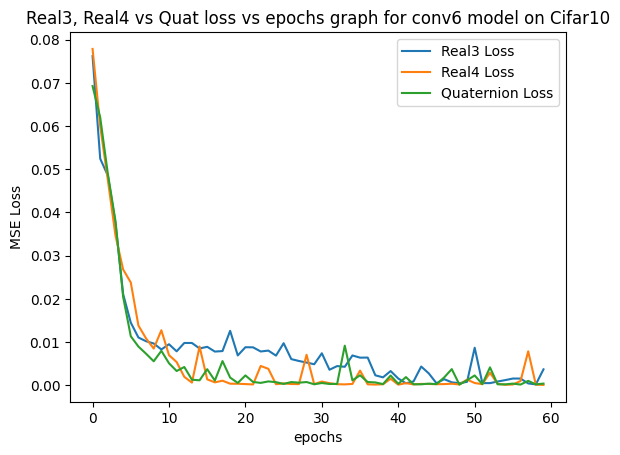

In [11]:
plt.plot(np.arange(len(loss_real3)), loss_real3, label='Real3 Loss')
plt.plot(np.arange(len(loss_real4)), loss_real4, label='Real4 Loss')
plt.plot(np.arange(len(loss_quat)),  loss_quat,  label='Quaternion Loss')
plt.xlabel('epochs')
plt.ylabel('MSE Loss')
plt.legend()
plt.title("Real3, Real4 vs Quat loss vs epochs graph for conv6 model on Cifar10")
plt.savefig('../docs/images/conv6_loss.png')
plt.show()

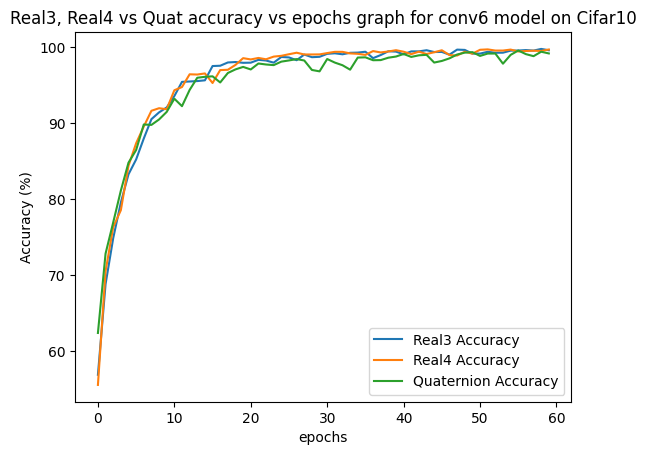

In [12]:
plt.plot(np.arange(len(accuracy_real3)), accuracy_real3, label='Real3 Accuracy')
plt.plot(np.arange(len(accuracy_real4)), accuracy_real4, label='Real4 Accuracy')
plt.plot(np.arange(len(accuracy_quat)),  accuracy_quat,  label='Quaternion Accuracy')
plt.xlabel('epochs')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.title("Real3, Real4 vs Quat accuracy vs epochs graph for conv6 model on Cifar10")
plt.savefig('../docs/images/conv6_accuracy.png')
plt.show()